In [1]:
import os.path as osp
import numpy as np
from torch_geometric.datasets import CitationFull
import torch
from torch_geometric.utils import to_dense_adj
from scipy import linalg

import pandas as pd
import networkx as nx
import numpy as np
import os.path as osp
import matplotlib.pyplot as plt

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.metrics import adjusted_rand_score
from sklearn.cluster import SpectralClustering

In [2]:
dataset = 'DBLP'
path = osp.join('.', 'data', dataset)
dataset = CitationFull(path, dataset)  # dowload or load the Cora dataset
data = dataset[0]

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/torch_geometric/data/dataset.py:238: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  if osp.exi

In [3]:
# Save the dataset to a .pth file 
torch.save(dataset, 'd3_dblp.pth')

In [4]:
data.node_attrs

<bound method BaseData.node_attrs of Data(x=[17716, 1639], edge_index=[2, 105734], y=[17716])>

In [5]:
labels = data.y.tolist()

In [6]:
set(labels)

{0, 1, 2, 3}

In [7]:
def spectral_clustering_on_graph(torch_data, labels, laplacian, number_of_clusters):

    adjacency_matrix = to_dense_adj(torch_data.edge_index).squeeze()
    # Convert the PyTorch tensor to a NumPy array
    adjacency_matrix = adjacency_matrix.numpy()

    dimension = len(adjacency_matrix)

    # Calculate degree matrix
    degree_matrix = np.sum(adjacency_matrix, axis=0) * np.eye(dimension)
    

    if laplacian == "sym":

        # Normalized Symmetric laplacian matrix
        d_half = linalg.fractional_matrix_power(degree_matrix, -0.5)
        laplacian_matrix_normalized = np.matmul(np.matmul(d_half, adjacency_matrix), d_half)

    if laplacian == "rw":

        # Normalized Random Walk laplacian matrix
        d_inverse = linalg.fractional_matrix_power(degree_matrix, -1)
        laplacian_matrix_normalized = np.matmul(d_inverse, adjacency_matrix)


    # Calculating eigenvalues and eigenvectors
    e, v = np.linalg.eigh(laplacian_matrix_normalized)

    # Eigen features for k
    k = number_of_clusters
    X = v[:, -1*k:]

    # Kmeans
    clustering = KMeans(n_clusters = number_of_clusters)
    clustering.fit(X)
    c_labels = clustering.fit_predict(X)

    # Create a copy of the data object by initializing a new Data instance
    # final_data = Data(
    #     edge_index=torch_data.edge_index,  # edge indices
    # )

    # final_df = torch_data.copy()
    # final_df['c_labels'] = c_labels
    # final_df['labels'] = labels
    
    cluster_labels = clustering.labels_
    
    return silhouette_score(X, cluster_labels), adjusted_rand_score(labels, cluster_labels)


In [8]:
laplacian_methods = ["sym", "rw"]

silhouette_scores = []
adjusted_rand_scores = []
laplacian = []


for laplace in laplacian_methods:

    laplacian.append(laplace)

    si, ar = spectral_clustering_on_graph(data, labels, laplace, 4)

    silhouette_scores.append(si)
    adjusted_rand_scores.append(ar)

In [9]:
experiment_cora = pd.DataFrame(list(zip(laplacian,silhouette_scores,adjusted_rand_scores)), 
             columns= ["laplacian", "silhouette", "adjusted_rand"])

experiment_cora

,laplacian,silhouette,adjusted_rand
0,sym,0.999165,-0.000238
1,rw,0.969618,0.000867


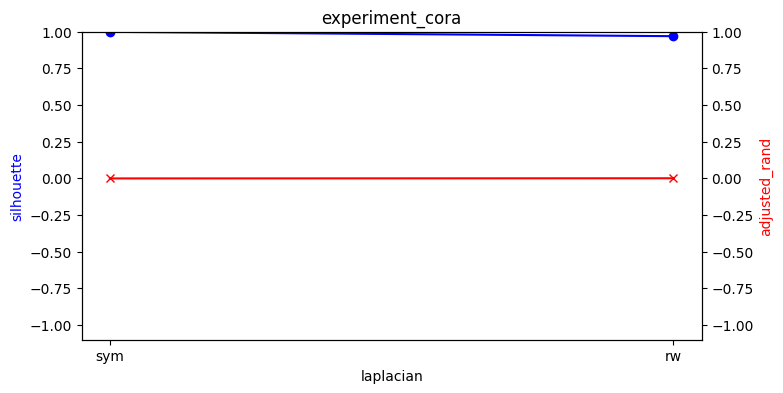

In [10]:
# Create a figure and axis
fig, ax = plt.subplots(figsize=(8, 4))

# Plot time on the first y-axis
ax.plot(experiment_cora['laplacian'], experiment_cora['silhouette'], marker='o', color='b', label='Time (seconds)')

# Create a second y-axis
ax2 = ax.twinx()

# Plot memory on the second y-axis
ax2.plot(experiment_cora['laplacian'], experiment_cora['adjusted_rand'], marker='x', color='r', label='Memory (KB)')

# Set labels and legends
ax.set_xlabel('laplacian')
ax.set_ylabel('silhouette', color='b')
ax2.set_ylabel('adjusted_rand', color='r')

ax.set_ylim(-1.1, 1)
ax2.set_ylim(-1.1, 1)  # Adjust the multiplier as needed


# Add legends
# ax.legend(loc='upper left')
# ax2.legend(loc='upper right')

# Show the plot
plt.title('experiment_cora')
plt.show()